In [62]:
import pandas as pd
import os
import seaborn as sns
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio import TreeNode
from io import StringIO

Metaadatok beolvasása

In [3]:
path_to_metadata = 'metadata_table.txt'
meta_df = pd.read_csv(path_to_metadata, delimiter = '\t', skiprows = [1])
meta_df.head()

,#SampleID,MouseId,TSampleId,Treatment,TreatmentDate,TreatmentDateCat,TreatmentExt,MiSeqId2
0,1,Ciprofloxacin_0.1_1,1_S1,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,1
1,2,Ciprofloxacin_0.1_2,2_S2,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,2
2,3,Ciprofloxacin_0.1_3,3_S3,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,3
3,4,Ciprofloxacin_0.1_4,4_S4,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,4
4,5,Ciprofloxacin_0.1_5,5_S5,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,5


Sample adatok beolvasása

Egy adott fájl feldolgozása

In [27]:
def get_data_for_sample(path_to_file):
    df = pd.read_csv(path_to_file, delimiter = '\t')
    sample_id = '_'.join(path_to_file.split('/')[-1].split('_')[0:2])
    df['TSampleId'] = sample_id
    not_found_files = set()
    try:
        df['Treatment'] = meta_df.loc[meta_df['TSampleId'] == sample_id]['Treatment'].item()
        df = df[['TSampleId', 'Treatment', 'name', 'taxonomy_lvl', 'new_est_reads', 'fraction_total_reads']]
        return df
    except: 
        #print(meta_df.loc[meta_df['TSampleId'] == sample_id]['Treatment'])
        #print("Not found file: ", sample_id)
        pass

Szükséges fájlok összegyűjtése

In [12]:
path = '//gfs/data/SE-OM/Klebsiella/trimmed_bracken/'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))

Fájlok beolvasása és egy dataframebe gyűjtése

In [28]:
df_list = []
for file in files:
    df = get_data_for_sample(file)
    if df is not None:
        df_list.append(get_data_for_sample(file))
df_union_all= pd.concat(df_list)

In [18]:
df_union_all.head()

,TSampleId,Treatment,name,taxonomy_lvl,new_est_reads,fraction_total_reads
0,19_S19,Ceftazidime_0.1,Muribaculaceae,F,65203,0.49823
1,19_S19,Ceftazidime_0.1,Bacteroidaceae,F,27395,0.20934
2,19_S19,Ceftazidime_0.1,Prevotellaceae,F,17232,0.13167
3,19_S19,Ceftazidime_0.1,Rikenellaceae,F,1421,0.01086
4,19_S19,Ceftazidime_0.1,Tannerellaceae,F,1595,0.01219


Egy szint kiválasztása: P (Pyhulm)

In [19]:
df_P = df_union_all.loc[df_union_all['taxonomy_lvl'] == 'P']

In [20]:
df_P.head()

,TSampleId,Treatment,name,taxonomy_lvl,new_est_reads,fraction_total_reads
0,11_S11,Ciprofloxacin_0.5,Bacteroidetes,P,127506,0.70613
1,11_S11,Ciprofloxacin_0.5,Firmicutes,P,25400,0.14067
2,11_S11,Ciprofloxacin_0.5,Verrucomicrobia,P,18288,0.10128
3,11_S11,Ciprofloxacin_0.5,Proteobacteria,P,7759,0.04297
4,11_S11,Ciprofloxacin_0.5,Cyanobacteria,P,1013,0.00561


In [24]:
sampleids = df_P["TSampleId"].drop_duplicates()
sampleids.head()

0    11_S11
0    18_S18
0    30_S30
0    24_S24
0    33_S33
Name: TSampleId, dtype: object

In [30]:
names = df_P["name"].drop_duplicates()
names = list(names)
names.sort()
names[0:5]

['Acidobacteria', 'Actinobacteria', 'Armatimonadetes', 'BRC1', 'Bacteroidetes']

Adathalmaz mátrix létrehozása

In [31]:
data = []
for sample in sampleids:
    rows = df_P.loc[df_P["TSampleId"] == sample]
    values = []
    for name in names:
        value = rows.loc[rows["name"] == name]
        if len(value) > 0:
            try:
                values.append(int(value.new_est_reads))
            except:
                print(value.new_est_reads)
        else:
            values.append(0)
    data.append(values)

In [34]:
ids = sampleids

Observed otus alpha diverzitás számolása

In [36]:
adiv_obs_otus = alpha_diversity('observed_otus', data, ids)

In [38]:
adiv_obs_otus.head()

TSampleId
11_S11    13
18_S18    13
30_S30    11
24_S24    11
33_S33    12
dtype: int64

Metaadatok csatolása és eredmény ábrázolása

In [57]:
meta = meta_df
meta.index = meta["TSampleId"]
joined = meta[["TSampleId", "MouseId", "Treatment"]].join(pd.DataFrame(adiv_obs_otus))
joined["ADIV"] = joined[0]
joined = joined.drop(columns=[0])

In [58]:
joined.head()

,TSampleId,MouseId,Treatment,ADIV
TSampleId,,,,
1_S1,1_S1,Ciprofloxacin_0.1_1,Ciprofloxacin_0.1,6.0
2_S2,2_S2,Ciprofloxacin_0.1_2,Ciprofloxacin_0.1,7.0
3_S3,3_S3,Ciprofloxacin_0.1_3,Ciprofloxacin_0.1,11.0
4_S4,4_S4,Ciprofloxacin_0.1_4,Ciprofloxacin_0.1,9.0
5_S5,5_S5,Ciprofloxacin_0.1_5,Ciprofloxacin_0.1,9.0


[Text(0, 0, 'Ciprofloxacin_0.1'),
 Text(0, 0, 'Ciprofloxacin_0.5'),
 Text(0, 0, 'Ceftazidime_0.1'),
 Text(0, 0, 'Ceftazidime_0.5'),
 Text(0, 0, 'Ampicillin_0.5'),
 Text(0, 0, 'Control'),
 Text(0, 0, 'Radak'),
 Text(0, 0, 'EFB_OB')]

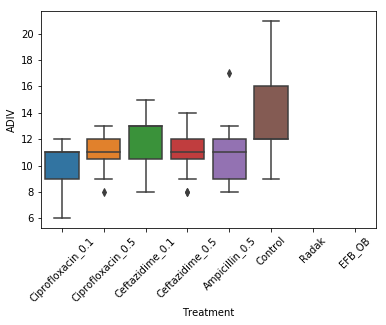

In [66]:
plt = sns.boxplot(x="Treatment", y="ADIV", data=joined)
plt.set_xticklabels(plt.get_xticklabels(),rotation=45)

Béta diverzitás számolása

In [63]:
bc_dm = beta_diversity("braycurtis", data, ids)

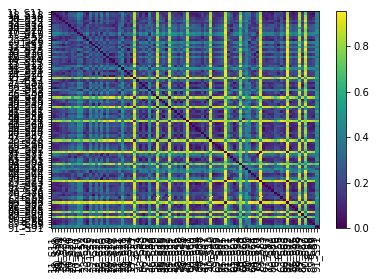

In [64]:
bc_dm